<a href="https://colab.research.google.com/github/FrancisKurian/CS530/blob/main/CS530_Week9_HousePrice_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW9
## Notes on the Modeling techniques

*   Removed duplicate features
*   Identified ordinal features and encoded them
*   Treated the missing values
*   Regrouped less freaquent categories to reduce sparse matrix(dummy variables)
*   Did Multicollinearity check on OLS with VIF
*   K-fold regularization on OLS
*   Multiple classification models with regularization attempted.

## Summary of Model performance on test data
#### Home Price Prediction-Regression: 
| Method |MAE| MSE|RMSE||            
| :- |--- |:-:|||
| OLS Base model |0.1264 |0.0327|0.1809||
| OLS Ridge | 0.1247 |0.0315|0.1776||  

#### Above Median Value Prediction-Classification:
| Method |Accuracy| Matthew's Coef|            
| :- | --- |:-:|
| Logistics Regression|0.8981 |0.7965|
| Random Forest-One Hot Encoding | 0.9023 |0.8052|  
| Random Forest-Label Encoding | 0.8981 |0.7965|  

### OLS with ridge regularization and Random Forest(one-hot encoding)  will be used for House Price prediction


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving house_SalePrice.csv to house_SalePrice.csv
Saving house_SalePrice_predict.csv to house_SalePrice_predict.csv


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [ ]:
df= pd.read_csv('house_SalePrice.csv')
df_p = pd.read_csv('house_SalePrice_predict.csv')
# df.info()

### Remove Duplicate Features

In [ ]:
df=df.drop(['Full Bath.1','Exter Cond.1',	'Bsmt Exposure.1',	'Heating QC.1'], axis=1)
# df.info()

### Ordinal Features: Encoding

In [ ]:
ordinal_features = ['Exter Cond',	'Bsmt Exposure',	'Heating QC']
ordinal_encoding = {'Exter Cond': {np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}, \
                    'Bsmt Exposure': {np.nan: 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}, \
                    'Heating QC': {np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}
df.replace(ordinal_encoding, inplace=True)
# df['Heating QC'].head()

### Missing Value Treatment

In [ ]:
nan_cols = [i for i in df.columns if df[i].isnull().sum()>=1]
print(nan_cols)

['Lot Frontage', 'Mas Vnr Type', 'Mas Vnr Area', 'BsmtFin SF 2']


In [ ]:
numerical_with_nan=[feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtypes!='O']
numerical_with_nan
for feature in numerical_with_nan:
    median_value=df[feature].median()
    df[feature].fillna(median_value,inplace=True)
df[numerical_with_nan].isnull().sum()

Lot Frontage    0
Mas Vnr Area    0
dtype: int64

In [ ]:
categorical_features=[feature for feature in df.columns if df[feature].dtype=='O']
for feature in categorical_features:
    print((df[feature].value_counts()))

In [ ]:
for feature in categorical_features:
    temp=df.groupby(feature)['Lot Area'].count()/len(df)
    temp_df=temp[temp>0.01].index
    df[feature]=np.where(df[feature].isin(temp_df),df[feature],'Rare_var')

In [ ]:
categorical_features=[feature for feature in df.columns if df[feature].dtype=='O']
for feature in categorical_features:
    print((df[feature].value_counts()))

In [ ]:
df['Condition 1'].replace({'RRAn' : 'Rare_var','PosN' : 'Rare_var'},inplace=True)
df['Functional'].replace({'Mod' : 'Rare_var'},inplace=True)

In [ ]:
df.isnull().sum()

In [ ]:
df['BsmtFin SF 2'].fillna(0,inplace=True)
df['SalePrice_binary'] = (df['SalePrice'] >df['SalePrice'].median())*1
df2=df.copy()

### log transformation of SalePrice

Skew is: 1.9112525306197887


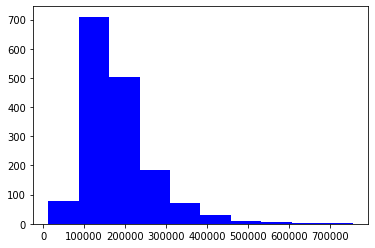

In [ ]:
print ("Skew is:", df.SalePrice.skew())
plt.hist(df.SalePrice, color='blue')
plt.show()

Skew is: 0.05191491454386725


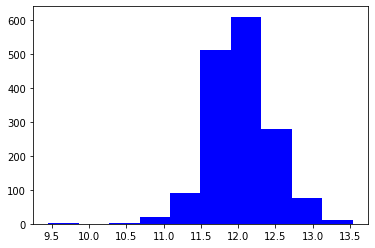

In [ ]:
target = np.log(df.SalePrice)
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

### Use one-hot enconding to convert the categorical variables into dummies.

In [ ]:
df = pd.get_dummies(df, drop_first=True)
df.shape

(1601, 42)

In [ ]:
df.info()

#### Training/Testing Splits 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['SalePrice','SalePrice_binary'], axis=1), 
                                                    np.log(df.SalePrice),
                                                    test_size=0.3,
                                                    random_state=1234)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1120, 40), (1120,), (481, 40), (481,))

### OLS Regression-Base Model

In [ ]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score
md=linear_model.LinearRegression().fit(X_train, y_train)
y_pred=md.predict(X_test)
y_pred_bi_ols =(y_pred> df['SalePrice'].median())*1

In [ ]:
print('Mean Absolute Error(MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error(MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:',metrics.r2_score(y_test,  y_pred))

Mean Absolute Error(MAE): 0.12640402236374523
Mean Squared Error(MSE): 0.03273764151667387
Root Mean Squared Error (RMSE): 0.18093546229712368
R2: 0.8040106417321932


### Multicolinearity Check with VIF

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
x_temp = sm.add_constant(X_train)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
vif["features"] = x_temp.columns
print(vif.round(1))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


    VIF Factor                 features
0    2533993.5                    const
1          2.1              MS SubClass
2          1.5             Lot Frontage
3          1.2                 Lot Area
4          2.8             Overall Qual
5          2.3             Mas Vnr Area
6          1.1               Exter Cond
7          1.5            Bsmt Exposure
8          1.1             BsmtFin SF 2
9          1.5               Heating QC
10         1.1          Low Qual Fin SF
11         2.0                Full Bath
12         1.8            Bedroom AbvGr
13         1.6            Kitchen AbvGr
14         2.0              Garage Cars
15         1.2           Enclosed Porch
16         1.1             Screen Porch
17         1.1                 Misc Val
18         1.1                  Yr Sold
19         2.4        Condition 1_Feedr
20         3.9         Condition 1_Norm
21         2.7     Condition 1_Rare_var
22         1.2     Condition 2_Rare_var
23         3.9       House Style_1Story


#### Grid Search for Ridge(l1) Regularization with k-fold cross validation

In [ ]:
from sklearn.model_selection import GridSearchCV
#lasso
params = {'alpha': [0.001, 0.01,.1,1,10,50,100,110, 120,130,140,150,200,500]}
ridge = linear_model.Ridge()

# cross validation
model_cv_l = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1)            

model_cv_l.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 110, 120,
                                   130, 140, 150, 200, 500]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [ ]:
print(model_cv_l.best_params_)
print(model_cv_l.best_score_)

{'alpha': 50}
-0.1307748237174483


### OLS Ridge Regression

In [ ]:
md=linear_model.Ridge(alpha =model_cv_l.best_params_['alpha']).fit(X_train, y_train)
y_pred=md.predict(X_test)
y_pred_bi_lasso =(np.exp(y_pred)> df['SalePrice'].median())*1
print('Mean Absolute Error(MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error(MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:',metrics.r2_score(y_test,  y_pred))

Mean Absolute Error(MAE): 0.12472493713821661
Mean Squared Error(MSE): 0.03153312608002467
Root Mean Squared Error (RMSE): 0.17757569112923274
R2: 0.811221674553


In [ ]:
np.exp(y_pred[:5])

array([137796.02810934, 295637.56351963, 177985.09267361, 203640.03974975,
       201091.75939615])

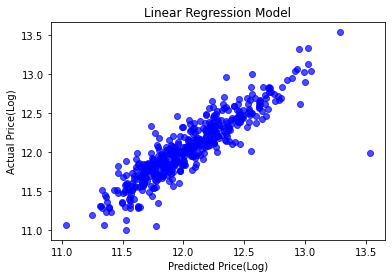

In [ ]:
plt.scatter(y_pred, y_test, alpha=.7,
            color='b') 
plt.xlabel('Predicted Price(Log)')
plt.ylabel('Actual Price(Log)')
plt.title('Linear Regression Model')
plt.show()

### Classification model - Train/Test splits

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['SalePrice','SalePrice_binary'], axis=1), 
                                                    df['SalePrice_binary'],
                                                    test_size=0.3,
                                                    random_state=1234)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1120, 40), (1120,), (481, 40), (481,))

### Logistics Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc,matthews_corrcoef
logr = LogisticRegression(random_state=0,penalty="none",max_iter=25000).fit(X_train, y_train)
y_pred=logr.predict(X_test) 
ac_lr=logr.score(X_test, y_test)
mc_lr=matthews_corrcoef(y_test, y_pred)
print(f'The accuracy of Logistic Regression : {ac_lr:.5}')
print(f'Mattews Correlation Coefficient is: {mc_lr:.5}')

The accuracy of Logistic Regression : 0.89813
Mattews Correlation Coefficient is: 0.79645


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=20,n_estimators=300, min_samples_leaf=2,min_samples_split=20,criterion='entropy', oob_score=True,random_state=42)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
mc_sk_income_rf=matthews_corrcoef(y_test, y_predict)
print(f'Accuracy of SKLearn Random Forest: {rf.score(X_test, y_test):.5}')
print(f'Matthews Coefficient for SKLearn Random Forest: {mc_sk_income_rf:.5}')

Accuracy of SKLearn Random Forest: 0.90229
Matthews Coefficient for SKLearn Random Forest: 0.80519


### Label encoding instead of one-hot for classification trees

In [ ]:
cat_columns = df2.select_dtypes(['object']).columns
cat_columns

Index(['Condition 1', 'Condition 2', 'House Style', 'Roof Style',
       'Mas Vnr Type', 'Heating', 'Functional', 'Sale Condition'],
      dtype='object')

In [ ]:
df2[cat_columns] = df2[cat_columns].apply(lambda x: pd.factorize(x)[0])
df2.head()

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(df2.drop(['SalePrice','SalePrice_binary'], axis=1), 
                                                    df2['SalePrice_binary'],
                                                    test_size=0.3,
                                                    random_state=1234)
X2_train.shape, y2_train.shape, X2_test.shape, y2_test.shape

((1120, 26), (1120,), (481, 26), (481,))

In [ ]:
rf = RandomForestClassifier(max_depth=30,n_estimators=300, min_samples_leaf=2,min_samples_split=20,criterion='entropy', oob_score=True,random_state=42)
rf.fit(X2_train, y2_train)
y2_predict = rf.predict(X2_test)
mc_sk_income_rf=matthews_corrcoef(y2_test, y2_predict)
print(f'Accuracy of SKLearn Random Forest: {rf.score(X2_test, y2_test):.5}')
print(f'Matthews Coefficient for SKLearn Random Forest: {mc_sk_income_rf:.5}')

Accuracy of SKLearn Random Forest: 0.89813
Matthews Coefficient for SKLearn Random Forest: 0.79645


### Observations on Various Models
#### Home Price Prediction: 
| Method |MAE| MSE|RMSE||            
| :- |--- |:-:|||
| OLS Base model |0.1264 |0.0327|0.1809||
| OLS Ridge | 0.1247 |0.0315|0.1776||  

### Above Median Value Prediction:
| Method |Accuracy| Matthew's Coef|            
| :- | --- |:-:|
| Logistics Regression|0.8981 |0.7965|
| Random Forest-One Hot Encoding | 0.9023 |0.8052|  
| Random Forest-Label Encoding | 0.8981 |0.7965|  

### OLS with ridge regularization and Random Forest(one-hot encoding)  will be used for House Price prediction


## Prediction for the houses in house_SalePrice_predict.csv
### Data Preperation -applying all steps in training data

In [ ]:
df_p=df_p.drop(['Full Bath.1','Exter Cond.1',	'Bsmt Exposure.1',	'Heating QC.1'], axis=1)
df_p.replace(ordinal_encoding, inplace=True)

In [ ]:
nan_cols = [i for i in df_p.columns if df_p[i].isnull().sum()>=1]
print(nan_cols)

['Lot Frontage', 'Mas Vnr Type', 'Mas Vnr Area', 'Garage Cars']


In [ ]:
numerical_with_nan=[feature for feature in df_p.columns if df_p[feature].isnull().sum()>1 and df_p[feature].dtypes!='O']
numerical_with_nan
for feature in numerical_with_nan:
    median_value=df_p[feature].median()
    df_p[feature].fillna(median_value,inplace=True)
df_p[numerical_with_nan].isnull().sum()

Lot Frontage    0
Mas Vnr Area    0
dtype: int64

In [ ]:
categorical_features=[feature for feature in df_p.columns if df_p[feature].dtype=='O']
for feature in categorical_features:
    print((df_p[feature].value_counts()))

In [ ]:
for feature in categorical_features:
    temp=df_p.groupby(feature)['Lot Area'].count()/len(df_p)
    temp_df=temp[temp>0.01].index
    df_p[feature]=np.where(df_p[feature].isin(temp_df),df_p[feature],'Rare_var')

In [ ]:
categorical_features=[feature for feature in df_p.columns if df_p[feature].dtype=='O']
for feature in categorical_features:
    print((df_p[feature].value_counts()))

In [ ]:
df_p['Condition 1'].replace({'RRAe' : 'Rare_var','PosA' : 'Rare_var'},inplace=True)
df_p['Heating QC'].replace({'Rare_var' : 'Ex'},inplace=True)
df_p['Sale Condition'].replace({'Alloca' : 'Rare_var'},inplace=True)
df_p['Garage Cars'].fillna(0,inplace=True)

In [ ]:
df_p = pd.get_dummies(df_p, drop_first=True)
df_p.shape

(400, 40)

In [ ]:
df_p.isnull().sum()

### Prediction

In [ ]:
# Price prediction using the Ridge Regression
y_pred_ridge=md.predict(df_p)
# Above Med price Prediction using Random Forest
y_pred_rf=rf.predict(df_p)

In [ ]:
# Storing the prediction results in a dataframe
prediction = pd.DataFrame(data = np.round(np.exp(y_pred_ridge),0), columns = ['BestSalePrice'])
prediction.insert(1, 'BestAboveMedian',y_pred_rf)
prediction.head(5)

,BestSalePrice,BestAboveMedian
0,184773.0,1
1,230972.0,1
2,128684.0,0
3,128895.0,0
4,135504.0,0


In [ ]:
#Creating final csv
prediction.to_csv(path_or_buf = 'kurian_prediction.csv', sep = ',', index = False, header = True)